In [64]:
import numpy as np
import scipy
import scipy.signal
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from itertools import product
from tqdm.notebook import trange

In [65]:
def plt_matrix(matrix, x_label, y_label, title):
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(matrix, aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    fig.axes[0].set_xlabel(x_label)
    fig.axes[0].set_ylabel(y_label)
    plt.title(title)
    plt.show()

# Reading in the soundfile

In [66]:
vl1 = read("vl1.wav")
vl1_freq = vl1[0]
vl1 = np.array(vl1[1], dtype=np.float32)
vl1_size = vl1.shape[0]

# Creating the Spectrogram

### Apply Hamming window

In [67]:
hamming = np.arange(vl1_size, dtype=np.float)
hamming = 0.54 - 0.46*np.cos((2*np.pi*hamming) / (vl1_size - 1))
vl1_hamming = hamming * vl1

### Calculating the spectrogram

In [68]:
WINDOW_SIZE = 1024
HOP_SIZE = int(WINDOW_SIZE / 4)

num_iters = int((vl1_size - WINDOW_SIZE) / HOP_SIZE)
spectrogram = np.empty((1024, num_iters), dtype=np.complex)
for i in range(num_iters):
    spectrogram[:, i] = np.fft.fft(vl1_hamming[HOP_SIZE*i : HOP_SIZE*i + WINDOW_SIZE])

### Plotting the spectrogram

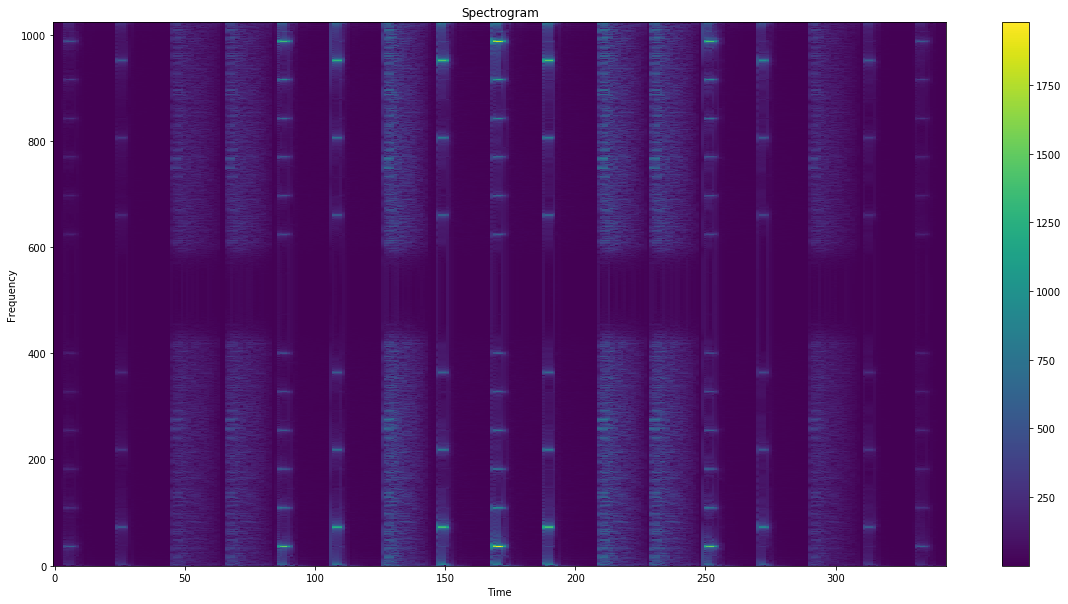

In [69]:
plt_matrix(np.sqrt(np.abs(spectrogram)), 'Time', 'Frequency', 'Spectrogram')

# Principal Components Analysis

In [70]:
def pca(input_matrix, output_features):
    mean = np.mean(input_matrix, axis=1)
    input_matrix = input_matrix - mean.reshape(mean.shape[0], 1)

    covariance = np.cov(input_matrix)
    U, _, _ = np.linalg.svd(covariance, hermitian=True)
    return U[:, :output_features]

# Independent Component Analysis

In [71]:
def fastica(X, iterations=500, threshold=1e-4):
    # taken from wikipedia pseudocode
    mean = np.mean(X, axis=1)
    X = X - mean.reshape(mean.shape[0], 1)

    M, N = X.shape
    W = np.random.rand(M, M)

    g = np.tanh
    g_prime = lambda x : 1 - np.square(np.tanh(x))

    for col in range(M):
        w = W[:, col].copy().reshape(M, 1)
        w = w / np.linalg.norm(w, ord=2)

        for _ in range(iterations):
            wg = np.matmul(X, g(np.matmul(w.T, X)).T) / N
            wgp = (np.sum(g_prime(np.matmul(w.T, X))) / N) * w
            new_w = wg - wgp

            #decorrelate weights
            new_w = new_w - np.sum(np.matmul(new_w.T, W[:, :col]) * W[:, :col], axis=1).reshape(new_w.shape)
            new_w = new_w / np.linalg.norm(new_w, ord=2)

            if (np.abs(w - new_w) < threshold).all():
                w = new_w
                break
            else:
                w = new_w
        W[:, col] = w.ravel()
    return W

# NMF

In [72]:
def nmf(X, output_features, iterations=100):
    '''
    Juan Jose Burred. Detailed Derivation of multiplicative update rules for NMF.
    https://www.jjburred.com/research/pdf/jjburred_nmf_updates.pdf
    '''
    M, N = X.shape

    W = np.random.rand(M, output_features)
    H = np.random.rand(output_features, N)
    for _ in range(iterations):
        # estimate H
        WH = np.matmul( W, H ) + 1e-10
        num = np.matmul (W.T, (X / WH) )
        den = np.matmul( W.T, np.ones((M, N)) )
        H = H * (num / den)

        # estimate new W
        WH = np.matmul( W, H ) + 1e-10
        num = np.matmul( (X / WH), H.T )
        den = np.matmul( np.ones((M, N)), H.T )
        W = W * (num / den)
    return W, H 
    

# Plotting the results

### PCA only

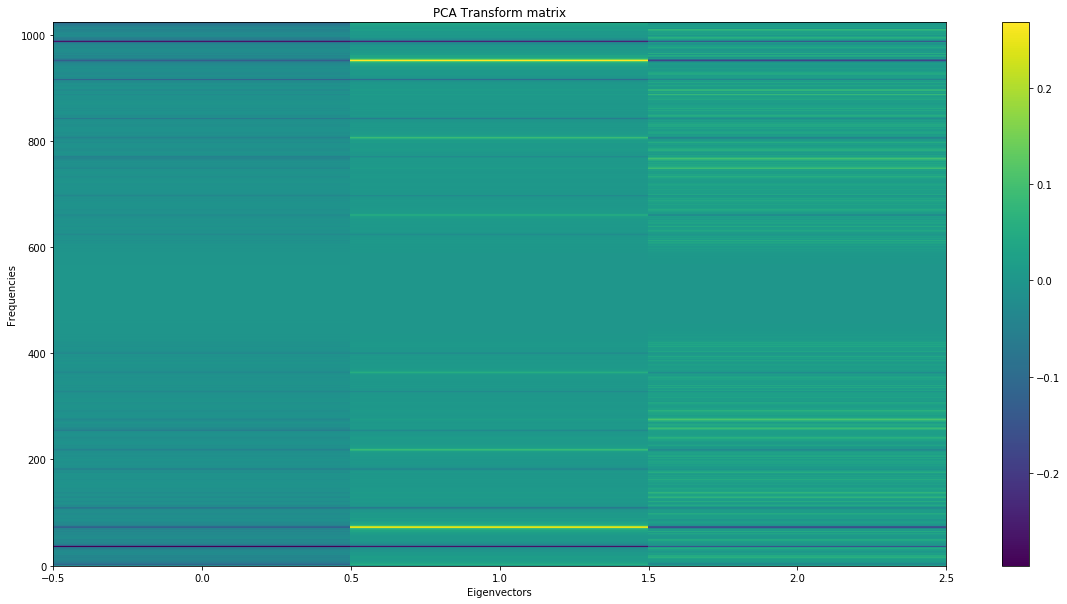

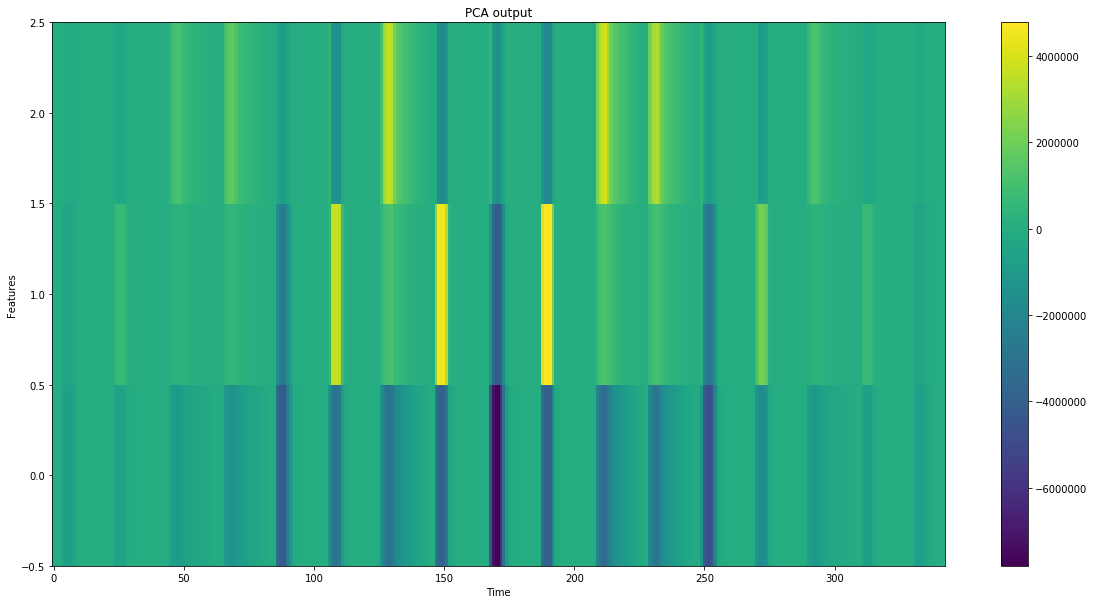

In [73]:
U = pca(np.abs(spectrogram), 3)
pca_spec = np.matmul(U.T, np.abs(spectrogram))

plt_matrix(U, 'Eigenvectors', 'Frequencies', 'PCA Transform matrix')
plt_matrix(pca_spec, 'Time', 'Features', 'PCA output')

### ICA transform

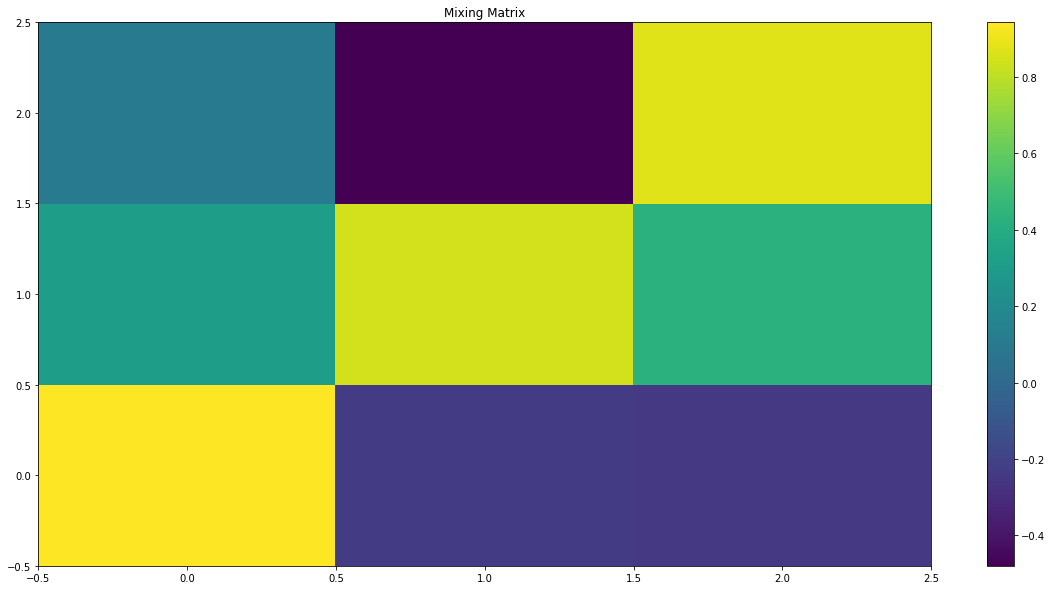

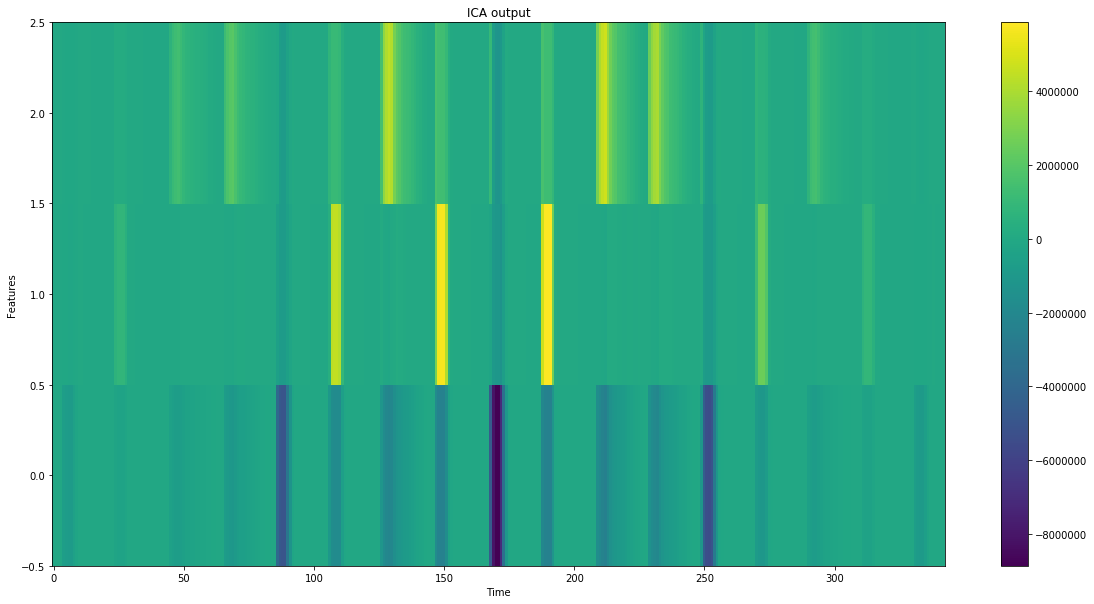

In [74]:
W = fastica(pca_spec)
ica_spec = np.matmul(W, pca_spec)

plt_matrix(np.linalg.inv(W), '', '', 'Mixing Matrix')
plt_matrix(ica_spec, 'Time', 'Features', 'ICA output')

### NMF

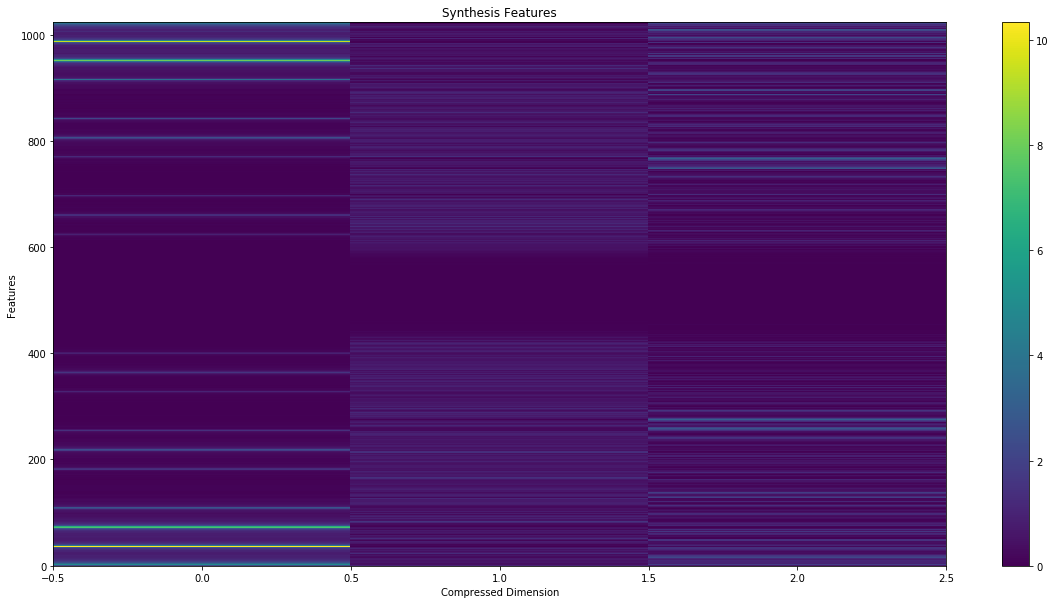

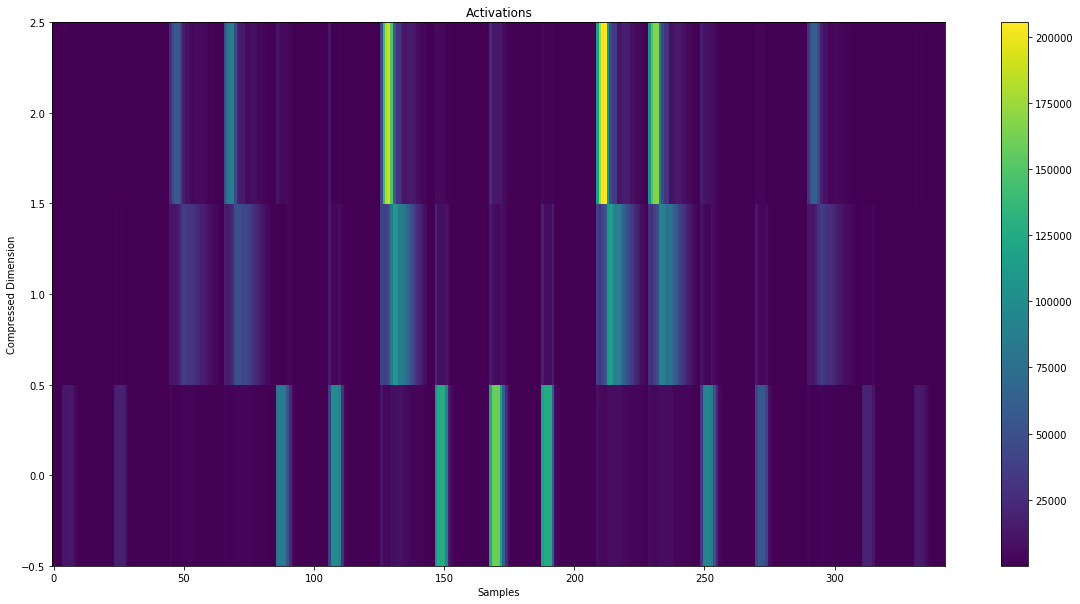

In [75]:
W, H = nmf(np.abs(spectrogram), 3)
plt_matrix(W, 'Compressed Dimension', 'Features', 'Synthesis Features')
plt_matrix(H, 'Samples', 'Compressed Dimension', 'Activations')

We can easily tell that the outputs of PCA and ICA are distinct vectors, however they do not give any information the underlying features and their meaning.
We cannot tell what instruments those vectors represent. However, with NMF, the vectors are very different, only activating at certain frequencies, similar to
the actual instruments. It makes it easier for humans to tell which instrument each vector represents. H represents the timings of when each instrument is activating.

# Handwritten Digits

In [76]:
digits_file = np.load('digits-labels.npz')
d = digits_file['d']

&lt;matplotlib.image.AxesImage at 0x7f9a0bb80ee0&gt;

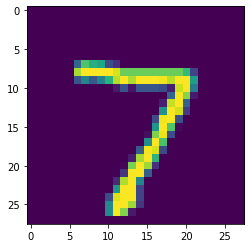

In [77]:
plt.imshow( np.reshape( d[:, 0], (28, 28), 'F' ))

### PCA on Digits

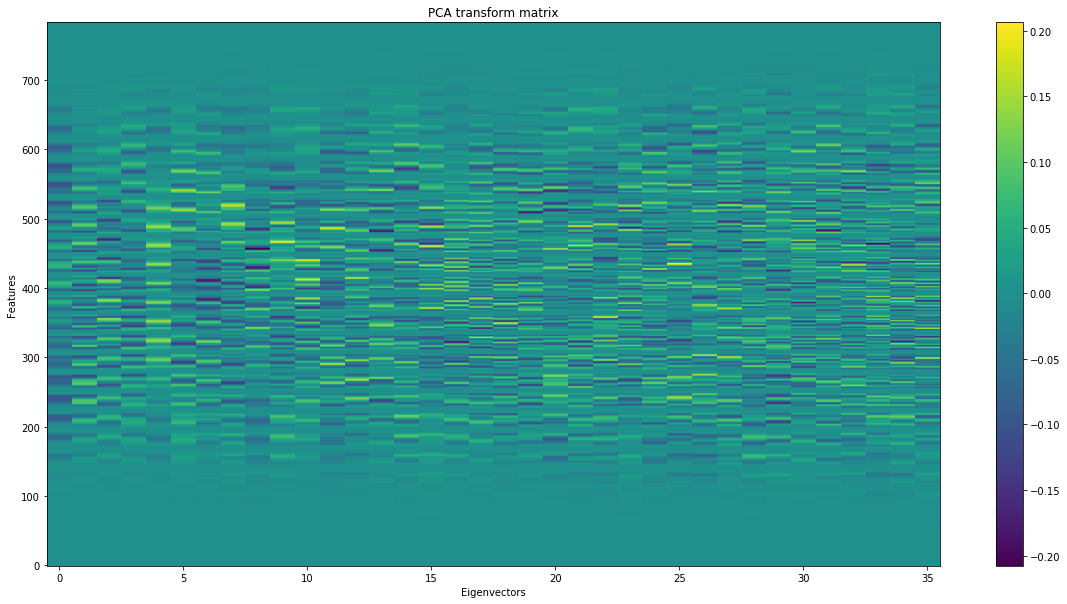

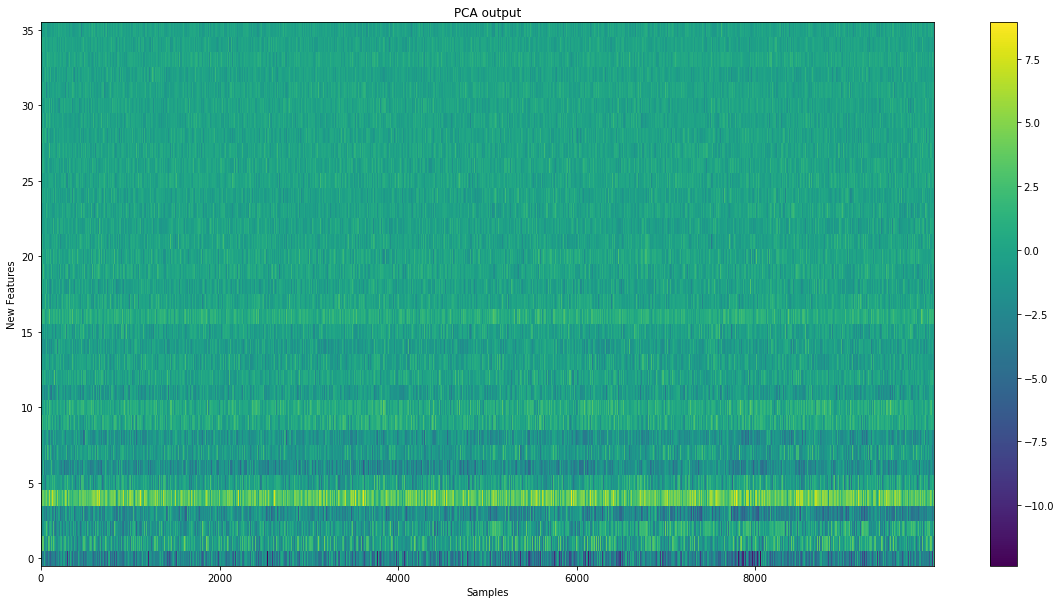

In [78]:
U = pca(d, 36)
pca_d = np.matmul(U.T, d)

plt_matrix(U, 'Eigenvectors', 'Features', 'PCA transform matrix')
plt_matrix(pca_d, 'Samples', 'New Features', 'PCA output')

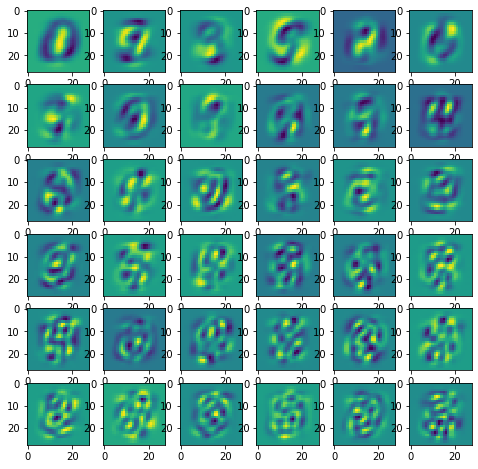

In [79]:
fig = plt.figure(figsize=(8,8))
rows, cols = (6, 6)
for i in range(1, cols*rows+1):
    img = np.reshape(U[:, i-1], (28,28), 'F')
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

### ICA on Digits

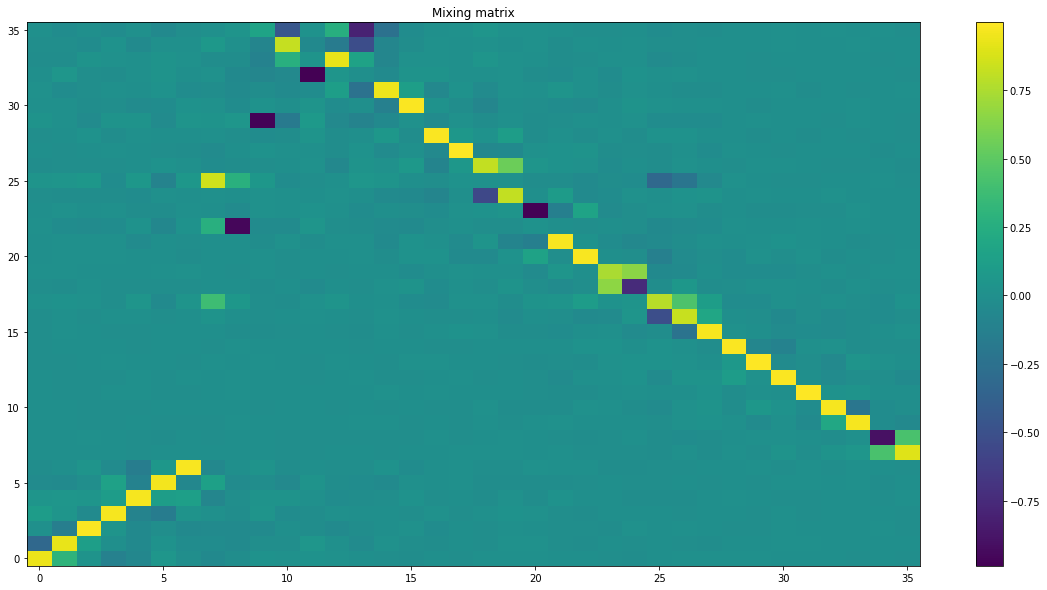

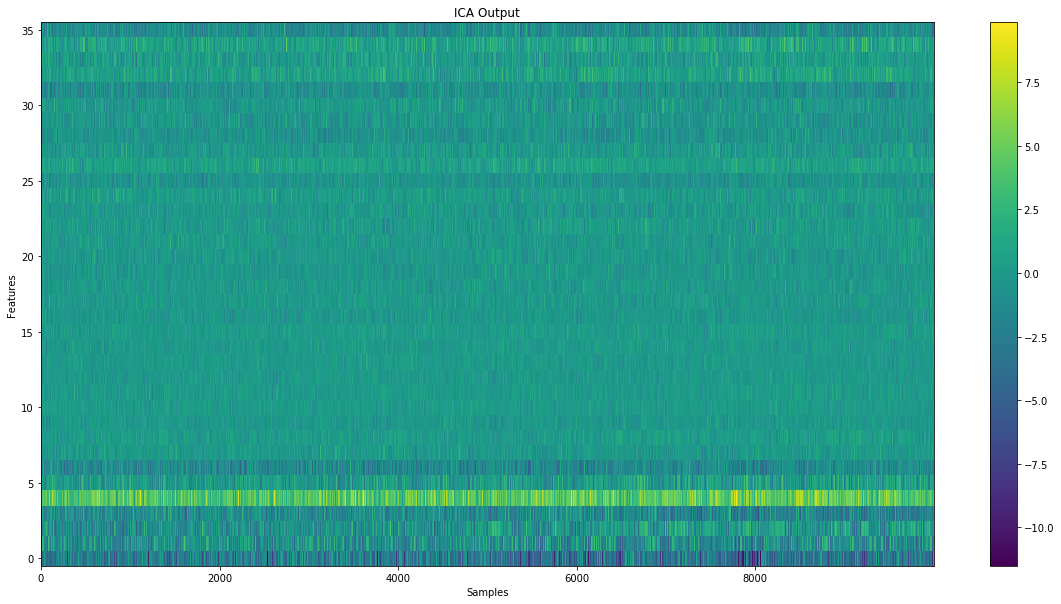

In [80]:
W = fastica(pca_d)
mixing = np.linalg.pinv(W)
ica_d = np.matmul(W, pca_d)

plt_matrix(mixing, '', '', 'Mixing matrix')
plt_matrix(ica_d, 'Samples', 'Features', 'ICA Output')

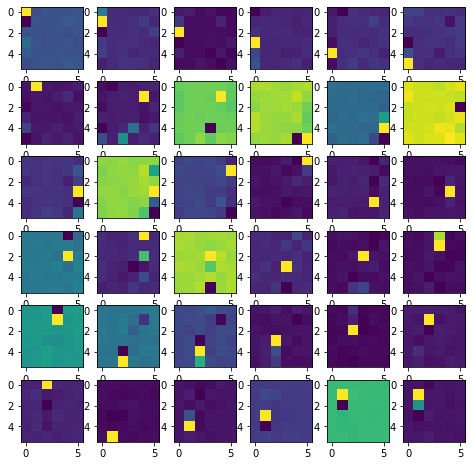

In [81]:
fig = plt.figure(figsize=(8,8))
rows, cols = (6, 6)
for i in range(1, cols*rows+1):
    img = np.reshape(mixing[:, i-1], (6,6), 'F')
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

### NMF on Digits

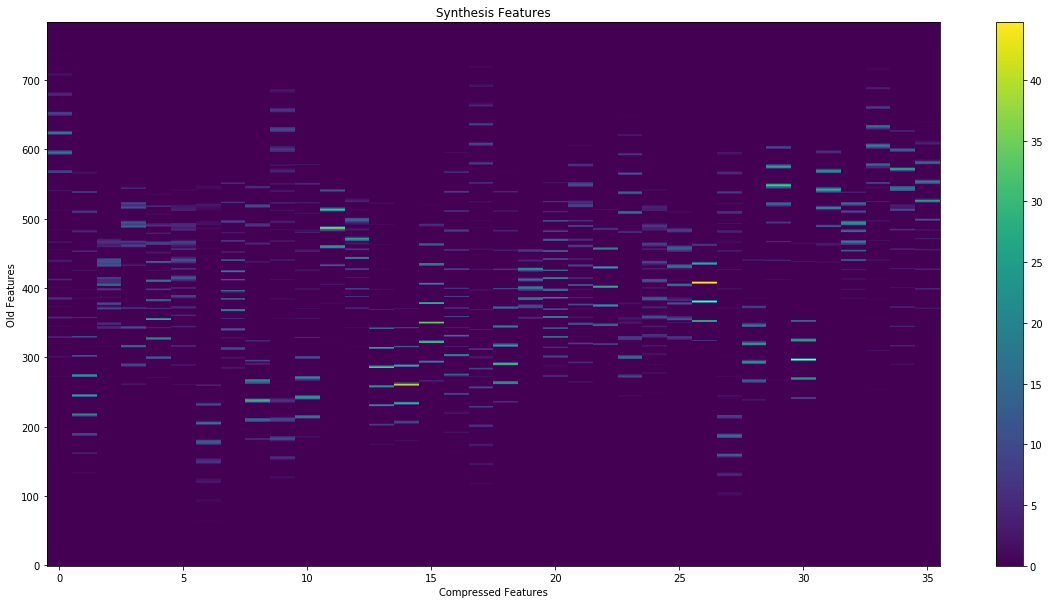

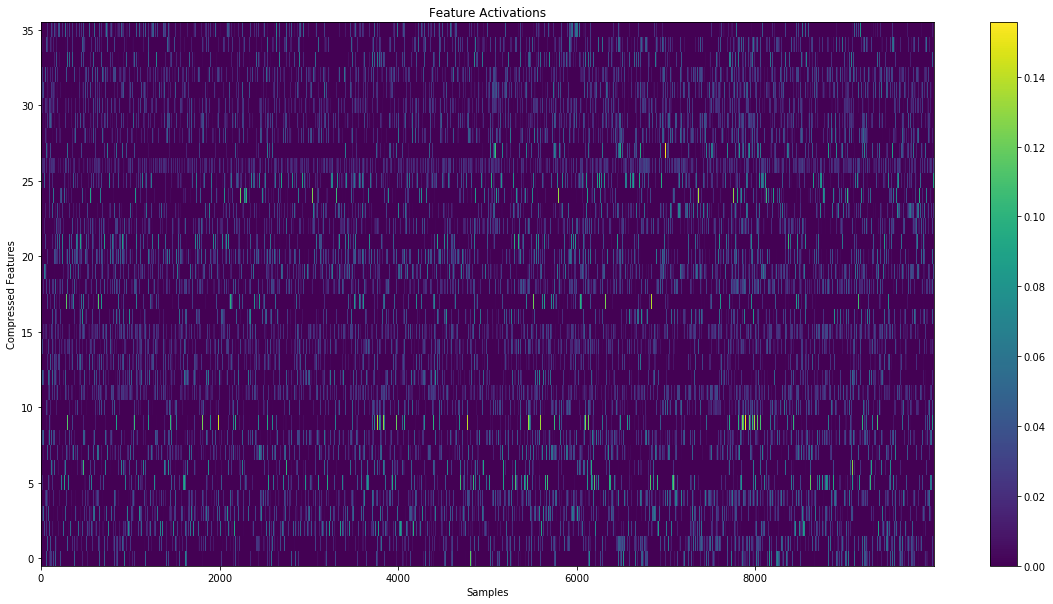

In [82]:
W, H = nmf(d, 36, iterations=100)

plt_matrix(W, 'Compressed Features', 'Old Features', 'Synthesis Features')
plt_matrix(H, 'Samples', 'Compressed Features', 'Feature Activations')

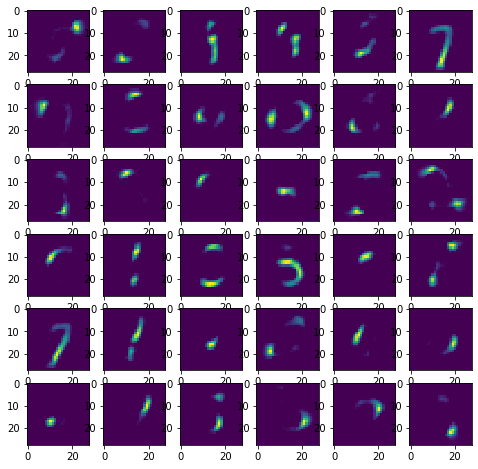

In [83]:
fig = plt.figure(figsize=(8,8))
rows, cols = (6, 6)
for i in range(1, cols*rows+1):
    img = np.reshape(W[:, i-1], (28,28), 'F')
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

The pca representation appears to return a sort of linear combination or mix of certain digits for each of its components. As the number of components increases, it becomes more messy and harder to distinguish the individual numbers. ICA returns a sort of individual activation vector, where each feature activates or deactivates a feature, kind of like switches. They are all distinct and activate different features. Obviously, NMF is the most interpretable. Each feature is a part of a number, and the H matrix shows how much of each number part is present in each sample. NMF is definitely best for human visualization.

# Geometry of Handwritten Digits

&lt;matplotlib.image.AxesImage at 0x7f9a14ae7f10&gt;

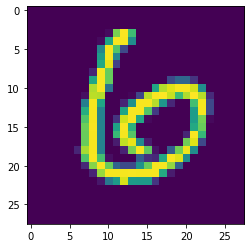

In [99]:
labels = digits_file['l']
sixes = d[:, labels==6]
img = np.reshape(sixes[:, 0], (28, 28), 'F')
plt.imshow(img)

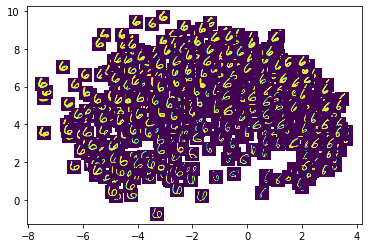

In [100]:
U = pca(sixes, 2)
pca_s = np.matmul(U.T, sixes)

NUM = 700
fig, ax = plt.subplots()
ax.scatter(pca_s[0, :NUM], pca_s[1, :NUM])

for i in range(pca_s[:, :NUM].shape[1]):
    img = OffsetImage(np.reshape(sixes[:, i], (28, 28), 'F'), zoom=0.5)
    ab = AnnotationBbox(img, pca_s[:, i], frameon=False)
    ax.add_artist(ab)

The sixes appear to become thinner and rotated as you move from left to right. However, the entire set appears to be curved upward, like its sitting on an upside down U shape.

In [101]:
def euclidean_dist(X):
    M, N = X.shape
    G = np.matmul(X.T, X)
    H = np.tile(np.diag(G), (N, 1))
    return H + H.T - 2*G

def adjacency_matrix(X, D, nearest_neighbors=6):
    '''
    X: Matrix of points with samples in columns
    D: Euclidean distance matrix between all pairs of points
    nearest_neighbors: number of connections to add for each point
    '''
    M, N = X.shape
    A = np.zeros((N, N), dtype=np.float)
    A[:] = np.inf
    
    for point in range(N):
        indices = np.argpartition(D[point, :], nearest_neighbors)[:nearest_neighbors]
        dist = D[point, :][indices]
        A[point, :][indices] = dist
    return np.minimum(A, A.T)

def floyd_warshall(A):
    # Weighted Adjacency matrix A can be used as distance matrix
    N, N = A.shape
    for k in range(N):
        comparison = np.tile(A[:, k].reshape(N, 1), (1, N)) + np.tile(A[k, :], (N, 1))
        index = A > comparison
        A[index] = comparison[index]
    return A


In [102]:
D = euclidean_dist(sixes)
A = adjacency_matrix(sixes, D)
geo = floyd_warshall(A)

In [103]:
def isomap(D, output_features=2):
    '''
    D: a matrix of pairwise geodesic distances
    '''
    N, N = D.shape
    ones = np.ones((N, N))

    first_term = np.matmul(D, ones) / N
    second_term = np.matmul(ones, D) / N
    third_term = np.matmul(ones, np.matmul(D, ones)) / (N**2)
    S = -0.5*(D - first_term - second_term + third_term)
    V, U = np.linalg.eigh(S)

    return np.matmul(np.diag(V[-output_features:]), U[:, -output_features:].T)

In [104]:
iso = isomap(geo)

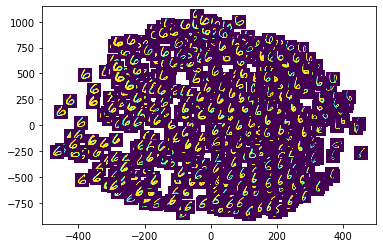

In [105]:
NUM = 700
fig, ax = plt.subplots()
ax.scatter(iso[0, :NUM], iso[1, :NUM])

for i in range(iso[:, :NUM].shape[1]):
    img = OffsetImage(np.reshape(sixes[:, i], (28, 28), 'F'), zoom=0.5)
    ab = AnnotationBbox(img, iso[:, i], frameon=False)
    ax.add_artist(ab)

This representation has the same feature, where the sixes become skinnier from left to right, however, the distribution is more normal now, and is not curved.